In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from holotomocupy.tomo import R,RT
from holotomocupy.holo import G,GT
from holotomocupy.magnification import M,MT
from holotomocupy.shift import S,ST
from holotomocupy.utils import *
# cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc)
%matplotlib inline

np.random.seed(10)

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 1024  # object size in each dimension
ntheta = 720  # number of angles (rotations)


theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6/1.5
energy = 17.05  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//8
show=True
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8
center = ne/2  # rotation axis

## Read real and imaginary parts of the refractive index u = delta+i beta

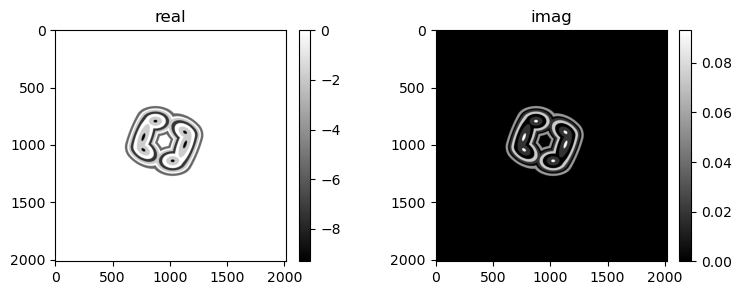

In [3]:
u = np.array(np.load(f'/data/vnikitin/phantoms/u{n}.npy')).astype('complex64')* voxelsize * 2*np.pi / wavelength*np.sqrt(ne*ntheta) # if already exists
u/=1.5
mshow_complex(u[ne//2],show)

In [4]:
# random sample shifts for each projection (note:before magnification)
shifts = (np.random.random([ntheta, ndist, 2]).astype('float32')-0.5)*n/32
# drift of the probe between different distances
shifts_ref = (np.random.random([1, ndist, 2]).astype('float32')-0.5)*n/128*0
# use the first ref image as the global reference for illumination
shifts_ref[0, 0, :] = 0

# use the first plane as the global reference for illumination
if ndist>1:
    shifts[:, 1] += np.array([0.6, 0.3])*3
    shifts[:, 2] += np.array([-1.3, 1.5])*3
    shifts[:, 3] += np.array([2.3, -3.5])*3

In [ ]:
def L2op(psi):
    data = np.zeros([psi.shape[0], ndist, n, n], dtype='complex64')
    for i in range(ndist):
        psir = psi[:,i].copy()
        psir = G(psir, wavelength, voxelsize, distances[i],'symmetric')
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LT2op(data):
    psi = np.zeros([data.shape[0],ndist, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(ndist):
        datar = data[:, j].copy()
        psir = np.pad(datar, ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j],'symmetric')        
        psi[:,j] = psir
    return psi

def L1op(psi):
    data = np.zeros([1, ndist, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(ndist):
        psir = psi.copy()
        psir = G(psir, wavelength, voxelsize, distances2[i],'symmetric')
        data[:, i] = psir
    return data#further broadcasting to ntheta

def LT1op(data):
    psi = np.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(ndist):
        datar = data[:, j].copy()
        psir = datar
        psir = GT(psir, wavelength, voxelsize, distances2[j],'symmetric')        
        psi += psir
    return psi

def S2op(psi,shifts):
    data = np.zeros([ntheta, ndist, ne, ne], dtype='complex64')
    #psi = cp.array(psi)
    for j in range(ndist):
        psir = psi.copy()
        shiftsr = shifts[:, j].copy()#/norm_magnifications[j])
        psir = S(psir, shiftsr)
        data[:,j] = psir
    return data

def ST2op(data,shifts):
    psi = np.zeros([ntheta, ne, ne], dtype='complex64')
    for j in range(ndist):
        datar = data[:,j].copy()#cp.array(data[:,j])
        shiftsr = shifts[:, j].copy()#/norm_magnifications[j])                
        psi += ST(datar,shiftsr)
    return psi

def S1op(psi):
    data = np.zeros([1, ndist, n+2*pad, n+2*pad], dtype='complex64')
    #psi = cp.array(psi)
    for i in range(ndist):
        psir = psi.copy()
        shiftsr = shifts_ref[:, i].copy()
        psir = S(psir, shiftsr)        
        data[:,i] = psir
    return data

def ST1op(data):
    psi = np.zeros([1, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(ndist):
        datar = data[:,j].copy()#cp.array(data[:,j])
        shiftsr = shifts_ref[:, j].copy()        
        psi += ST(datar,shiftsr)
    return psi

def Mop(psi):
    res = np.zeros([ntheta, ndist, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(ndist):
        res[:,i] = M(psi[:,i], norm_magnifications[i]*ne/(n+2*pad), n+2*pad)                        
    return res

def MTop(psi):
    res = np.zeros([ntheta, ndist, ne, ne], dtype='complex64')
    for i in range(ndist):        
        res[:,i] = MT(psi[:,i], norm_magnifications[i]*ne/(n+2*pad), ne)        
    return res

def Rop(u):
    res = R(u,theta,center)
    return res.swapaxes(0,1)    

def RTop(data):
    res = RT(data.swapaxes(0,1),theta,center)
    return res    



# adjoint tests
arr1 = np.random.random([1,n+2*pad,n+2*pad]).astype('complex64')
# shifts_ref = cp.random.random([1,ndist,2]).astype('float32')
arr2 = S1op(arr1)
arr3 = ST1op(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = np.random.random([1,n+2*pad,n+2*pad]).astype('complex64')
arr2 = L1op(arr1)
arr3 = LT1op(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = np.random.random([ntheta,ne,ne]).astype('complex64')
shifts_test = np.random.random([ntheta,ndist,2]).astype('float32')
arr2 = S2op(arr1,shifts_test)# note magnification needed
arr3 = ST2op(arr2,shifts_test)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = np.random.random([ntheta,ndist,ne,ne]).astype('complex64')
arr2 = Mop(arr1)
arr3 = MTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = np.random.random([ntheta,ndist,n+2*pad,n+2*pad]).astype('complex64')
arr2 = L2op(arr1)
arr3 = LT2op(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = np.random.random([ne,ne,ne]).astype('complex64')
arr2 = Rop(arr1)
arr3 = RTop(arr2)
print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')



(2186849.5+0j)==
(2186848+0j)
(2181288.25+0.04737013578414917j)==
(2181287.75-4.953974439558806e-06j)
(3902111488-0.12477217614650726j)==
(3940991232+4.3209070099692326e-08j)


## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

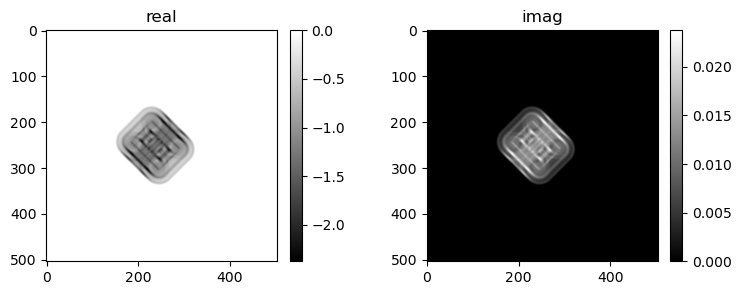

In [ ]:
Ru = Rop(u)
mshow_complex(Ru[0],show)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

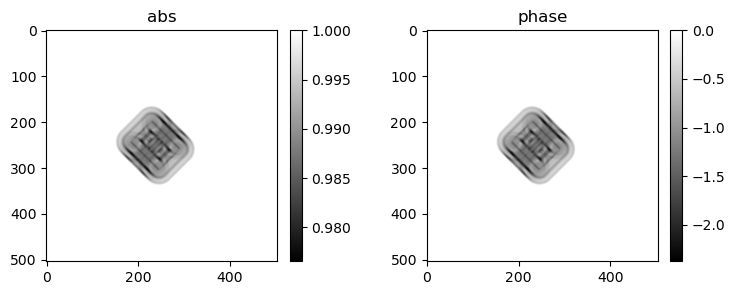

In [ ]:
psi = np.exp(1j*Ru)
mshow_polar(psi[0],show)

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

File ‘../data/prb_id16a/prb_abs_2048.tiff’ already there; not retrieving.

File ‘../data/prb_id16a/prb_phase_2048.tiff’ already there; not retrieving.



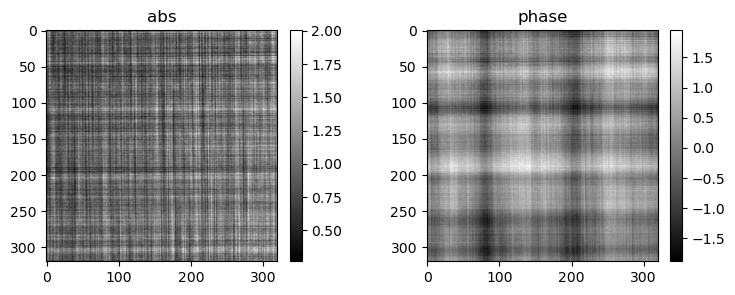

In [ ]:
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_abs_2048.tiff -P ../data/prb_id16a
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_phase_2048.tiff -P ../data/prb_id16a

prb_abs = read_tiff(f'../data/prb_id16a/prb_abs_2048.tiff')[0:1]
prb_phase = read_tiff(f'../data/prb_id16a/prb_phase_2048.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')


for k in range(2*256//n):
    prb = prb[:, ::2]+prb[:, 1::2]
    prb = prb[:, :, ::2]+prb[:, :, 1::2]/4

prb = prb[:, n//2-pad:-n//2+pad, n//2-pad:-n//2+pad]
prb /= np.mean(np.abs(prb))

mshow_polar(prb[0],show)

# Smooth the probe, the loaded one is too noisy

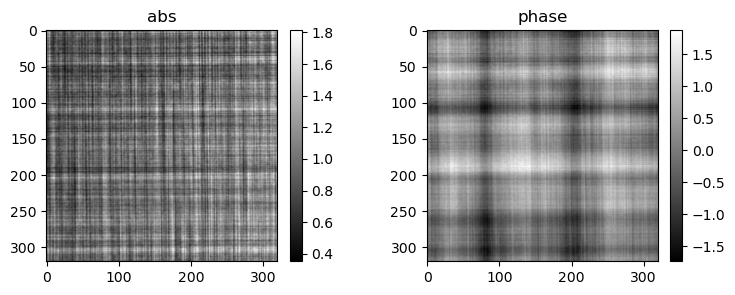

In [ ]:
v = np.arange(-(n+2*pad)//2,(n+2*pad)//2)/(n+2*pad)
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-5*(vx**2+vy**2))
prb = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(prb)))
prb = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(prb*v)))
prb = prb.astype('complex64')

mshow_polar(prb[0],show)

### Compute holographic projections for all angles and all distances
#### $$d_{j,k}=|L_{2,j}(L_{1,j}(q)\cdot M_j(S_{{x}_{j,k}}(c_k)))|^2$$

### Take squared absolute value to simulate data on the detector and a reference image

In [ ]:
eRu = np.exp(1j*Rop(u))
L2psi = L2op(L1op(prb)*Mop(S2op(eRu,shifts)))
data = np.abs(L2psi)**2


eRu = np.exp(1j*Rop(u*0))
L2psi = L2op(L1op(prb)*Mop(S2op(eRu,shifts)))
ref = np.abs(L2op(L1op(prb)*(1+0*Mop(S2op(psi,shifts)))))**2
ref = ref[0]


### Visualize data

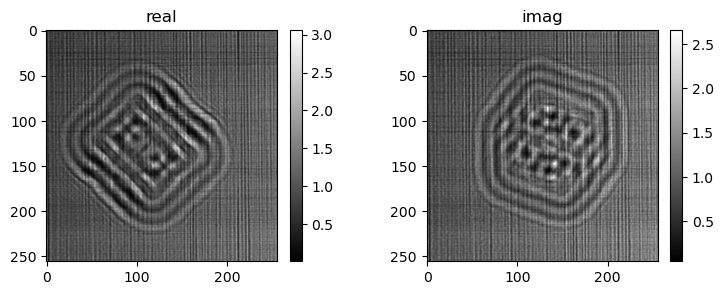

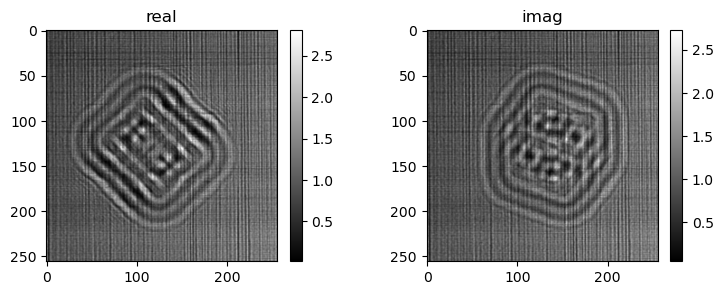

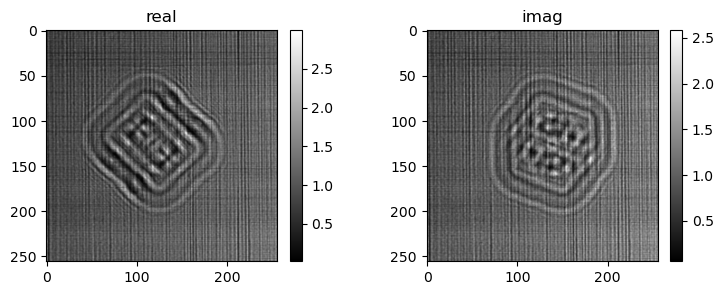

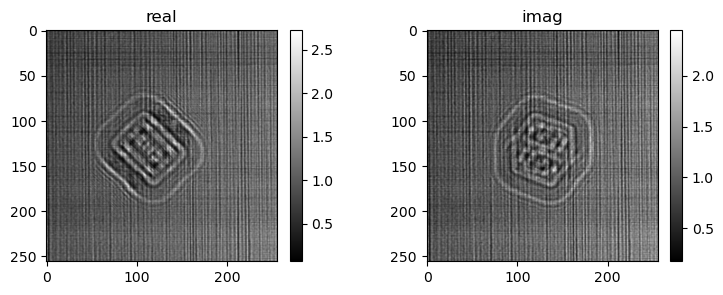

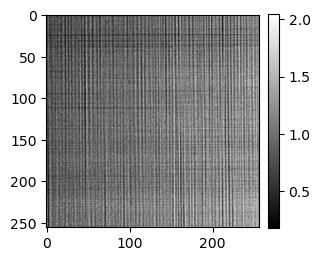

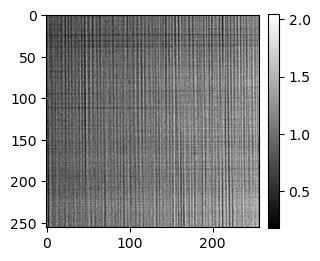

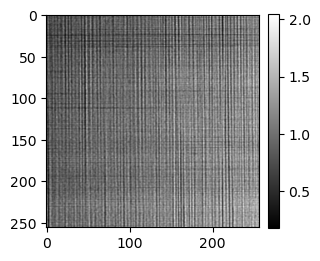

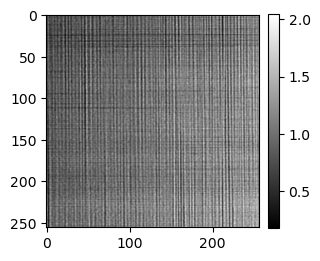

In [ ]:
for k in range(ndist):
    mshow_complex(data[0,k]+1j*data[ntheta//2,k],show)
for k in range(ndist):
    mshow(ref[k],show)    


### Save data, reference images

In [ ]:
np.save(f'/data/vnikitin/data{n}',data)
np.save(f'/data/vnikitin/ref{n}',ref)
np.save(f'/data/vnikitin/shifts{n}', shifts)
np.save(f'/data/vnikitin/shifts_ref{n}', shifts_ref)

err=(np.random.random([ntheta,ndist,2])-0.5)*4
np.save(f'/data/vnikitin/shifts_err{n}', err)
